# Lab 1 - Differential Expression analysis
## Differential expression analysis, an intuition

In [2]:
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
from ipywidgets import interact, interact_manual
from ipywidgets import IntSlider, FloatSlider

interact_gen=interact_manual.options(manual_name="Generate data")
interact_plot=interact_manual.options(manual_name="Plot")

In [3]:
def generate_data(distance,dispersion, n_points):
    dispersion = [[dispersion,0],[0,dispersion]]
    cond1 = np.random.multivariate_normal([0,0], dispersion, n_points)
    cond2 = np.random.multivariate_normal([distance,0], dispersion, n_points)
    data1 = pd.DataFrame(cond1, columns=['x','y'])
    data1['Condition'] = 1
    data2 = pd.DataFrame(cond2, columns=['x','y'])
    data2['Condition'] = 2
    data = pd.concat([data1,data2])
    return data

def generate_h0(distance,dispersion, n_points):
    dispersion = [[dispersion + (distance/2)**2,0],[0,dispersion]]
    cond1 = np.random.multivariate_normal([distance/2,0], dispersion, n_points)
    cond2 = np.random.multivariate_normal([distance/2,0], dispersion, n_points)
    data1 = pd.DataFrame(cond1, columns=['x','y'])
    data1['Condition'] = 1
    data2 = pd.DataFrame(cond2, columns=['x','y'])
    data2['Condition'] = 2
    data = pd.concat([data1,data2])
    return data

def plot_random(data,data_s):
    f, ax = plt.subplots(1, 2)
    r1 = np.random.permutation(2)
    colors = np.random.permutation(['red','blue']).tolist()
    sns.scatterplot(x='x', y='y', data=data, hue = 'Condition', palette=colors, ax = ax[r1[0]], legend  = False)
    sns.scatterplot(x='x', y='y', data=data_s, hue = 'Condition', palette=colors, ax = ax[r1[1]], legend = False)

def dist_plot(Distance,Dispersion,Samples):
    plt.rcParams["figure.figsize"] = (20,10)
    data = generate_data(Distance,Dispersion, Samples)
    data_s = generate_h0(Distance,Dispersion, Samples)
    plot_random(data,data_s)
    plt.show()

In [4]:
interact(dist_plot, Distance = FloatSlider(min=0,max=10, continuous_update=False), Dispersion = FloatSlider(min=0,max=100, continuous_update=False), Samples=IntSlider(min=5,max=100, continuous_update=False))

interactive(children=(FloatSlider(value=0.0, continuous_update=False, description='Distance', max=10.0), Float…

<function __main__.dist_plot(Distance, Dispersion, Samples)>

### Questions

## The t-test

In [6]:
def plot_random_ttest(data,data_s):
    plt.rcParams["figure.figsize"] = (20,10)
    cond1 = data[data['Condition'] == 1]
    cond2 = data[data['Condition'] == 2]
    cond1_s = data_s[data_s['Condition'] == 1]
    cond2_s = data_s[data_s['Condition'] == 2]
    ttestp = sp.stats.ttest_ind(cond1, cond2).pvalue[0]
    ttestp_s= sp.stats.ttest_ind(cond1_s, cond2_s).pvalue[0]
    f, ax = plt.subplots(1, 2)
    r1 = np.random.permutation(2)
    colors = np.random.permutation(['red','blue']).tolist()
    sns.scatterplot(x='x', y='y', data=data, hue = 'Condition', palette=colors, ax = ax[r1[0]], legend  = False)
    ax[r1[0]].set_title('p = ' + str(np.round(ttestp, 5)))
    sns.scatterplot(x='x', y='y', data=data_s, hue = 'Condition', palette=colors, ax = ax[r1[1]], legend = False)
    ax[r1[1]].set_title('p = ' + str(np.round(ttestp_s,5)))
    

def dist_plot_ttest(Distance,Dispersion,Samples):
    plt.rcParams["figure.figsize"] = (20,10)
    data = generate_data(Distance,Dispersion, Samples)
    data_s = generate_h0(Distance,Dispersion, Samples)
    plot_random_ttest(data,data_s)
    plt.show()

In [7]:
interact(dist_plot_ttest, Distance = FloatSlider(min=0,max=10, continuous_update=False), Dispersion = FloatSlider(min=0,max=100, continuous_update=False), Samples=IntSlider(min=5,max=100, continuous_update=False))

interactive(children=(FloatSlider(value=0.0, continuous_update=False, description='Distance', max=10.0), Float…

<function __main__.dist_plot_ttest(Distance, Dispersion, Samples)>

Questions: 
* What assumptions about the data doest the t-test make?
* Are they compatible with gene expression data? If not, how to go around it? 

## Exercise, differential gene expression analysis

## Multiple hypothesis

In [65]:
def multiple_tests(distance,dispersion, n_points, n_tests):
    h0_stats = []
    h1_stats = []
    for i in range(n_tests):
        data = generate_data(distance,dispersion, n_points)
        data_h0 = generate_h0(distance,dispersion, n_points)
        cond1 = data[data['Condition'] == 1]
        cond2 = data[data['Condition'] == 2]
        cond1_s = data_h0[data_h0['Condition'] == 1]
        cond2_s = data_h0[data_h0['Condition'] == 2]
        ttestp = sp.stats.ttest_ind(cond1, cond2).pvalue[0]
        ttestp_s= sp.stats.ttest_ind(cond1_s, cond2_s).pvalue[0]
        h0_stats.append(ttestp_s)
        h1_stats.append(ttestp)
    return h0_stats, h1_stats

def plot_hist(h0_stats, h1_stats, bins):
    plt.rcParams["figure.figsize"] = (20,10)
    f, ax = plt.subplots(1, 2)
    sns.distplot(h0_stats, bins = bins, ax = ax[0], kde=False, hist_kws={"range": [0,1]})
    sns.distplot(h1_stats, bins = bins, ax = ax[1], kde=False, hist_kws={"range": [0,1]})
    #ax[0].hist(h0_stats, bins = bins)
    #ax[1].hist(h1_stats, bins = bins)
    ax[0].set_title('H0')
    ax[0].set_xlim([0,1])
    ax[1].set_title('H1')
    ax[1].set_xlim([0,1])
    plt.show()
    
def plot_hist_comb(h0_stats, h1_stats, bins, threshold):
    plt.rcParams["figure.figsize"] = (20,10)
    f, ax = plt.subplots(1, 2)
    ax[0].hist([h0_stats, h1_stats], bins = bins, stacked = True)
    ax[0].vlines(threshold, 0, max(np.histogram([h0_stats,h1_stats], bins=bins)[0]), color='r', linestyles = 'dashed')
    stats = pd.DataFrame(h1_stats + h0_stats, columns = ['p'])
    stats['h'] = np.repeat(1,len(h1_stats)).tolist() + np.repeat(0,len(h0_stats)).tolist()
    stats['good'] = (stats['p'] <= threshold)*1
    stats = stats.sort_values('p')
    stack1 = stats['h']
    stack2 = stats['good']
    side = np.ceil(np.sqrt(len(stack1))).astype(int)
    pad1 = np.zeros(side*side)+9
    pad2 = np.zeros(side*side)+9
    pad1[:len(stack1)]=stack1
    pad2[:len(stack1)]=stack2 * 5
    ax[1].imshow(pad1.reshape(side,side), cmap = 'Set1')
    ax[1].imshow(pad2.reshape(side,side), cmap = 'Set1', alpha = 0.4)
    plt.show()
    
def plot_hist_pi0(h0_stats, h1_stats, bins, threshold, pi0):
    plt.rcParams["figure.figsize"] = (20,10)
    plt.hist([h0_stats, h1_stats], bins = bins, stacked = True)
    plt.vlines(threshold, 0, max(np.histogram([h0_stats,h1_stats], bins=bins)[0]), color='r', linestyles = 'dashed')
    stats = pd.DataFrame(h1_stats + h0_stats, columns = ['p'])
    stats['h'] = np.repeat(1,len(h1_stats)).tolist() + np.repeat(0,len(h0_stats)).tolist()
    stats = stats.loc[stats['p'] <= threshold]
    fdr_true = 1 - sum(stats['h'])/len(stats['h'])
    m = len(h0_stats + h1_stats)
    fdr_est = (pi0*m*threshold)/len(stats['h'])
    h = pi0*m/bins
    plt.hlines(h, 0, 1, color='black', linestyles = 'dashed', linewidth=3)
    print(fdr_true, fdr_est)
    plt.show()
    
def interactive_generate(Distance, Dispersion, Samples, Tests):
    global G_h0_results, G_h1_results
    G_h0_results, G_h1_results = multiple_tests(Distance,Dispersion, Samples, Tests)
    
def interactive_double_hist(Bins):
    plot_hist(G_h0_results, G_h1_results, Bins)

def interactive_plot_hist_comb(Bins, Threshold):
    plot_hist_comb(G_h0_results, G_h1_results, Bins, Threshold)

In [10]:
interactive_generate(1, 1, 3, 100)
interact_gen(interactive_generate, Distance = FloatSlider(min=0.0,max=10.0), Dispersion = FloatSlider(min=1.0,max=100.0), Samples = IntSlider(min=5,max=100), Tests = IntSlider(min=5,max=1000))
interact_plot(interactive_double_hist, Bins=IntSlider(min=10,max=100, step = 10, continuous_update=False))

interactive(children=(FloatSlider(value=0.0, description='Distance', max=10.0), FloatSlider(value=1.0, descrip…

interactive(children=(IntSlider(value=10, continuous_update=False, description='Bins', min=10, step=10), Butto…

<function __main__.interactive_double_hist(Bins)>

## Calculating FDR

In [11]:
interact_gen(interactive_generate, Distance = FloatSlider(min=0.0,max=10.0), Dispersion = FloatSlider(min=0.0,max=100.0), Samples = IntSlider(min=0,max=100), Tests = IntSlider(min=0,max=1000))
interact(interactive_plot_hist_comb, Threshold = FloatSlider(min=0,max=0.5, step = 0.01, continuous_update=False), Bins=IntSlider(min=10,max=100, step = 10, continuous_update=False))

interactive(children=(FloatSlider(value=0.0, description='Distance', max=10.0), FloatSlider(value=0.0, descrip…

interactive(children=(IntSlider(value=10, continuous_update=False, description='Bins', min=10, step=10), Float…

<function __main__.interactive_plot_hist_comb(Bins, Threshold)>

0.037735849056603765 0.03786163522012578


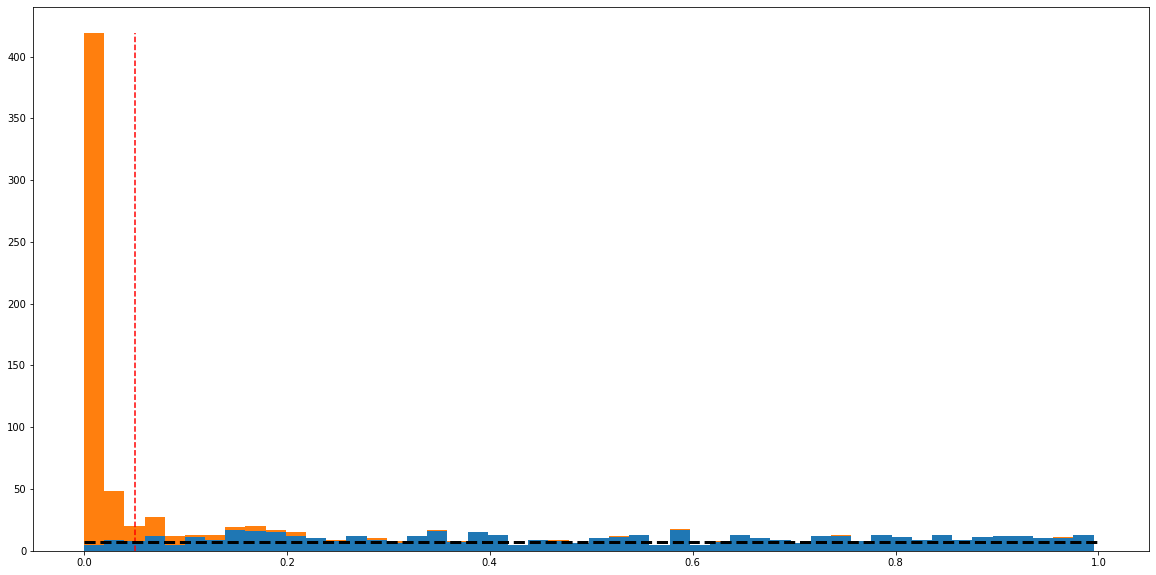

In [70]:
plot_hist_pi0(G_h0_results, G_h1_results, 50, 0.05, 0.35)

## Exercise

## Volcano plot